# LOGISTIC REGRESSION ALGORITHM on Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Loading,Cleaning & Preprocessing the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".*italicized text*

In [0]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

####Import all Required Libraries 

In [0]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#### Pull the dataset from Google Drive & mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Connect to sqlite and fetch the data using SQL Query

In [4]:
con = sqlite3.connect("/content/drive/My Drive/Colab Notebooks/database.sqlite")

filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""",con);
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
filtered_data.shape

(525814, 10)

In [6]:
def partition(x):
  if x < 3 :
    return 'negative'
  return 'positive'

actualScore=filtered_data['Score']
positive_negative=actualScore.map(partition)
filtered_data['Score']=positive_negative
print("Number of datapoints",filtered_data.shape)
filtered_data.head(3)

Number of datapoints (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head(3)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2


In [9]:
display[display["UserId"]=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [10]:
display['COUNT(*)'].sum()

393063

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [12]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [13]:
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

#### Count the Positive and Negative Review Counts

In [16]:
print(final_data.shape)

#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Import nltk library

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Find the Stopping Words

In [18]:
stopping_words = set(stopwords.words('english'))
print(stopping_words)

{'what', "hasn't", 'which', 'in', 'd', 'haven', 'y', 'with', 'after', 'his', 'other', 'don', 'll', "shouldn't", 'won', 'of', 'down', 'from', 'couldn', 'didn', 'only', "you're", 'where', 's', 'and', 'or', 'who', 'had', "she's", 'further', 'myself', 'too', 'into', "shan't", 'ma', "won't", 'against', 'at', 'hers', 'them', 'same', 'their', "you'll", 'can', 'both', 'own', 'hasn', 'ourselves', 'herself', 'few', 'if', 're', "doesn't", 'once', 've', "needn't", 'not', 'but', 'about', "hadn't", 'out', 'all', 'until', 'here', 'mustn', 'for', "you'd", 'when', 'each', "mightn't", 'to', 'o', 'no', "haven't", 'any', 'an', 'm', 'i', 'been', 'nor', 'him', 'did', "that'll", 'our', 'on', 'through', 'should', 'very', 'most', 'is', "didn't", "isn't", "weren't", 'your', 'why', 'doesn', "you've", 'whom', 'than', 'we', 'under', 'again', 'the', 'were', 'then', 'doing', 'so', 'mightn', 'below', 'theirs', 'me', 'before', 'now', 'wasn', 'being', 'there', 'am', 'aren', 'ours', "wasn't", 'over', 'that', "wouldn't",

In [0]:
def clean_html(text):
    clean_r = re.compile('<,*?>')
    clean_text = re.sub(clean_r,'',text)
    return clean_text

def Clean_punc(text):
    clean_sentence = re.sub(r'[?|!|\'|"|#]',r' ',text)
    clean_data = re.sub(r'[.|,|)|(|\|/)]',r' ',clean_sentence)
    return clean_data

In [20]:
from tqdm import tqdm
import os
import pdb
import pickle

from tqdm import tqdm
import os
import pdb
import pickle

stem_no = nltk.stem.SnowballStemmer('english')

if not os.path.isfile('final_data.sqlite'):
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    for i,sentence in enumerate(tqdm(final_data['Text'].values)):
        filtered_sentence=[]
        sent_without_html_tags=clean_html(sentence)
        #pdb.set_trace()
        for w in sent_without_html_tags.split():
            for cleaned_words in Clean_punc(w).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                    if(cleaned_words.lower() not in stopping_words) :
                        stemming=(stem_no.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(stemming)
                        if(final_data['Score'].values)[i]=='positive':
                            all_positive_words.append(stemming)
                        if(final_data['Score'].values)[i]=='negative':
                            all_negative_words.append(stemming)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        
    final_data['Cleaned_text']=final_string
    final_data['Cleaned_text']=final_data['Cleaned_text'].str.decode("utf-8")    
    
    conn = sqlite3.connect('final_data.sqlite')
    cursor=conn.cursor
    conn.text_factory = str
    final_data.to_sql('Reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl','wb') as f :
        pickle.dump(all_positive_words,f)
    with open('negative_words.pkl','wb') as f :
        pickle.dump(all_negative_words,f)

100%|██████████| 364171/364171 [06:15<00:00, 970.86it/s]


#### Find the Total Number of Words in the Review Text

In [0]:
final_data['total_words'] = [len(x.split()) for x in final_data['Cleaned_text'].tolist()] 

In [22]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,34
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,27
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,15


In [0]:
final_data.sort_values(by=['Time'], inplace=True, ascending=True)

In [24]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,34
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,30
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,13


In [25]:
final_data.shape

(364171, 12)

In [26]:
final_data_100K=final_data[0:100000]
amazon_polarity_labels=final_data_100K['Score'].values
final_data_100K.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,34
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,30


#### Split the data into Train , Test and CV

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_1,X_Test,Y_1,Y_Test = train_test_split(final_data_100K,amazon_polarity_labels,test_size=0.2,random_state=0)
X_Train,X_CV,Y_Train,Y_CV = train_test_split(X_1,Y_1,test_size=0.2)

In [0]:
X_Train.to_csv('amazonfine_food_train_data.csv') 

In [29]:
X_Train.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text,total_words
360148,389532,B000EDBPO8,A1Y6YLMUA88TV7,J. Shaath,0,0,positive,1264204800,good quality,This white rice flour is fine instead of coars...,white rice flour fine instead coars like great...,18
86841,94545,B0006TV6OE,A3KG5T5FOXSCOV,"Charlie Steinson ""Charlie""",0,3,negative,1263513600,Don't order this if on a low carb diet or diab...,The wrapper claims only 4 net carbs per servin...,wrapper claim net carb per serv bar subtract f...,22
101615,110385,B000UW5M9W,A2L01339XV496V,Patricia Smith,6,6,positive,1267833600,Don't be afraid of buying in bulk!,We all know how expensive artichoke hearts are...,know expens artichok heart yet favorit recip d...,75


In [30]:
print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


count_vector=CountVectorizer(min_df=1)
X_Train_data_bow=(count_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_bow=(count_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_bow=(count_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_bow.shape, Y_Train.shape)
print(X_CV_data_bow.shape, Y_CV.shape)
print(X_Test_data_bow.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 29469) (64000,)
(16000, 29469) (16000,)
(20000, 29469) (20000,)


### Use Logistic Regression Algorithm and GridSearchCV using 10 Fold Cross Validation to find Best Alpha

In [0]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def Logistic_Regression_Optimal_C(x_training_data,y_training_data):
  grid_params = { 'C' : [10**x for x in range(-5,4)]              
                 }
  logistic_regression = LogisticRegression(random_state=None, class_weight=None)
  clf=GridSearchCV(logistic_regression,grid_params,scoring='roc_auc',return_train_score=True,cv=10)
  clf.fit(x_training_data,y_training_data)
  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_C'])
  train_auc= results['mean_train_score']
  train_auc_std= results['std_train_score']
  cv_auc = results['mean_test_score'] 
  cv_auc_std= results['std_test_score']
  C =  results['param_C']
  #print(type(alpha))
  #print(alpha)
  log_c=np.log10(list(results["param_C"]))
  print(clf.best_score_)
  print(clf.best_params_)
  plt.plot(log_c, train_auc, label='Train AUC')
  plt.plot(log_c, cv_auc, label='CV AUC')
  plt.scatter(log_c, train_auc, label='Train AUC points')
  plt.scatter(log_c, cv_auc, label='CV AUC points')
  plt.legend()
  plt.xlabel("C: hyperparameter")
  plt.ylabel("AUC")
  plt.title("Hyper parameter Vs AUC plot")
  plt.grid()
  plt.show()
  return results,clf,logistic_regression

0.9296777946680457
{'C': 0.1}


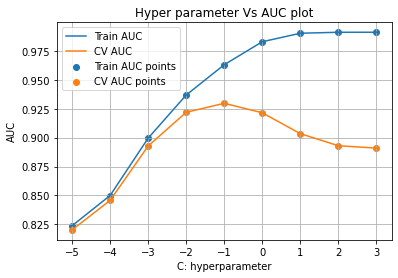

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.429887,0.007426,0.028884,0.000816,1e-05,{'C': 1e-05},0.816206,0.809677,0.824734,0.817418,0.822045,0.819689,0.826141,0.817344,0.826308,0.821997,0.820156,0.004926,9,0.826772,0.820489,0.823705,0.822478,0.825001,0.822966,0.823034,0.824072,0.824040,0.824915,0.823747,0.001601
1,0.412549,0.011324,0.028783,0.000618,0.0001,{'C': 0.0001},0.840353,0.839678,0.849942,0.846365,0.846737,0.846633,0.849634,0.843252,0.849583,0.844921,0.845710,0.003498,8,0.851577,0.848682,0.849808,0.849367,0.849812,0.849239,0.849611,0.850193,0.849948,0.850859,0.849910,0.000783
2,0.543292,0.012814,0.028957,0.000383,0.001,{'C': 0.001},0.886338,0.893569,0.895706,0.897847,0.893190,0.893653,0.894563,0.891146,0.893989,0.887294,0.892730,0.003386,6,0.900118,0.899511,0.899304,0.899208,0.898916,0.899245,0.899487,0.899539,0.899521,0.900303,0.899515,0.000395
3,1.095692,0.052711,0.028767,0.000523,0.01,{'C': 0.01},0.921654,0.924067,0.924452,0.928075,0.920517,0.920799,0.921826,0.921261,0.921096,0.915475,0.921922,0.003080,2,0.936527,0.937018,0.936410,0.936658,0.936489,0.937079,0.936926,0.936854,0.936848,0.937467,0.936828,0.000304
4,2.264165,0.028399,0.028764,0.000349,0.1,{'C': 0.1},0.934950,0.931076,0.930742,0.935660,0.926494,0.927150,0.928869,0.928481,0.927543,0.925812,0.929678,0.003237,1,0.962631,0.963186,0.963000,0.962991,0.963194,0.963148,0.962834,0.963340,0.962890,0.963483,0.963070,0.000239


In [32]:
results,best_c,Logistic_Regression_Optimal_C = Logistic_Regression_Optimal_C(X_Train_data_bow,Y_Train)
results.head()

## Using Logistic Regression on Bag OF Words , The Optimal Value of C = 0.1 and Accuracy = 0.9293...

In [33]:
best_C = best_c.best_params_
best_c=best_C.get("C")
print(best_c)

0.1


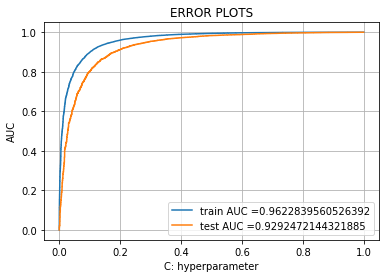

In [34]:
from sklearn.metrics import roc_curve, auc

logistic_reg = LogisticRegression(C=best_c,random_state=None, class_weight=None)
logistic_reg.fit(X_Train_data_bow,Y_Train)
pred_test_data=logistic_reg.predict(X_Test_data_bow)
y_train_predicted_prob = logistic_reg.predict_proba(X_Train_data_bow)[:,1]
y_test_predicted_prob=logistic_reg.predict_proba(X_Test_data_bow)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### BY LOOKING AT THE GRAPH , THE TRAIN AUC = 0.9614.. AND TEST AUC = 0.9300..

### FIND THE TOP 20 POSITIVE AND NEGATIVE FEATURES

In [35]:
feature_names = count_vector.get_feature_names()
print(feature_names)
coefs_with_fns = sorted(zip(logistic_reg.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

['aaa', 'aaaaaaaaagghh', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah', 'aaah', 'aaahhhhhh', 'aachen', 'aacur', 'aaf', 'aafco', 'aah', 'aahh', 'aalmost', 'aand', 'aardvark', 'ab', 'aback', 'abandon', 'abattoir', 'abba', 'abbey', 'abbi', 'abbott', 'abbrevi', 'abc', 'abd', 'abdomen', 'abdomin', 'aber', 'aberdeen', 'abhor', 'abhorr', 'abi', 'abid', 'abigirl', 'abil', 'abit', 'abita', 'abj', 'abl', 'ablaz', 'abliti', 'abnorm', 'abod', 'abomin', 'abondanza', 'aboout', 'aborio', 'abosolut', 'abot', 'aboth', 'abou', 'abound', 'abour', 'abouy', 'abouyt', 'abovement', 'aboveour', 'abp', 'abpv', 'abras', 'abreva', 'abrevi', 'abroad', 'abrupt', 'abruzzo', 'abscess', 'abscond', 'absenc', 'absens', 'absensc', 'absent', 'absinth', 'absolu', 'absolulti', 'absolut', 'absolutali', 'absoluteki', 'absolutelli', 'absolutelti', 'absolutley', 'absolv', 'absorb', 'absorbt', 'absorpt', 'absoult', 'absoulut', 'absout', 'abstain', 'abstract', 'absulut', 'absurd', 'abt', 'abu', 'abud', 'abuela', 'abuelita', 'abum',

[((-2.160114502017787, 'worst'), (1.4720981968491202, 'delici')),
 ((-1.57737780496826, 'terribl'), (1.3382979566189583, 'excel')),
 ((-1.5235684925772264, 'disappoint'), (1.2743398099781318, 'perfect')),
 ((-1.5205848303736005, 'bland'), (1.2722028214899557, 'best')),
 ((-1.4750041539836685, 'horribl'), (1.1706319430190184, 'great')),
 ((-1.3409612561369968, 'return'), (1.1029968456002295, 'amaz')),
 ((-1.3219831368478137, 'threw'), (1.0949674364031627, 'addict')),
 ((-1.3098381626032183, 'aw'), (1.0142716547466408, 'yummi')),
 ((-1.2412542391072634, 'tasteless'), (0.9649815643441443, 'beat')),
 ((-1.15974152981675, 'unfortun'), (0.9628143526724355, 'hook')),
 ((-1.1319660226677657, 'stale'), (0.9595063431094906, 'awesom')),
 ((-1.1077658603574856, 'sorri'), (0.9497114203720983, 'satisfi')),
 ((-1.0308874481764474, 'money'), (0.9268681019088533, 'wonder')),
 ((-1.025668735420536, 'ruin'), (0.9245726512896841, 'nice')),
 ((-0.9968855390231548, 'unpleas'), (0.8790290626229103, 'thank'))

### ROC AUC SCORE = 0.9300..

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_Test,y_test_predicted_prob)

0.9292472144321885

In [37]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.79      0.52      0.63      2457
    positive       0.94      0.98      0.96     17543

    accuracy                           0.92     20000
   macro avg       0.87      0.75      0.79     20000
weighted avg       0.92      0.92      0.92     20000

[[ 1285  1172]
 [  333 17210]]


### Find the Weight W for the Model

In [0]:
weight_w1=logistic_reg.coef_

In [39]:
weight_w1

array([[-9.54484428e-03,  1.34033485e-03,  9.57209191e-03, ...,
        -4.18750044e-02,  3.49458247e-05,  3.24138399e-04]])

In [40]:
print(weight_w1.shape)

(1, 29469)


### Adding Small Noice using random function

In [0]:
import copy 
noise_data = copy.deepcopy(X_Train_data_bow)

In [0]:
from scipy.sparse import csr_matrix
noise_data=csr_matrix(noise_data,dtype=np.float64)

In [43]:
type(noise_data)

scipy.sparse.csr.csr_matrix

In [0]:
add_noice=np.random.normal(0,0.01)

In [45]:
print(add_noice)

0.011160311560311106


In [46]:
type(add_noice)

float

### Adding the Noice to BoW Trainig Data

In [47]:
noise_data.data += add_noice
print(noise_data.shape)

(64000, 29469)


### Fit the Model on NOISE DATA and get the Weight W'

In [0]:
logistic_reg_new = LogisticRegression(C=best_c,random_state=None, class_weight=None)
logistic_reg_new.fit(noise_data,Y_Train)
weight_w2=logistic_reg_new.coef_

In [49]:
weight_w2.shape

(1, 29469)

### CALCULATE THE AVERAGE DIFFERENCE IN WEIGHT VECTORS 

In [50]:
coef_diff = weight_w2 - weight_w1
print ("Average difference in weight vectors : ",np.mean(coef_diff))

Average difference in weight vectors :  1.5990948651124464e-06


### Add the small eps value to avoid the divide by zer error 
### W1' = W1 + 10^-6
### W2' = W2 + 10^-6

In [0]:
weight_w1_dash = weight_w1 + 0.000001
weight_w2_dash = weight_w2 + 0.000001

### Find the Percentage Change between W1 & W2 using (| (W1-W2) / (W1) |)*100)

In [0]:
percentage_difference = (abs((weight_w1_dash- weight_w2_dash)/weight_w1_dash)) * 100

In [0]:
sorted_array=np.sort(percentage_difference)

reverse_array=sorted_array[::-1]

In [54]:
type(percentage_difference)

numpy.ndarray

In [55]:
percentage_difference.shape

(1, 29469)

## FIND THE NTH PERCENTILE 

In [58]:
print('The First 100th Percentile')

for i in range(100):
  print(" The Percentile = ",i,np.percentile(percentage_difference,i))

The First 100th Percentile
 The Percentile =  0 0.00012988504120639484
 The Percentile =  1 0.01704106652529466
 The Percentile =  2 0.031667209716234816
 The Percentile =  3 0.04680951695573926
 The Percentile =  4 0.06296934141459282
 The Percentile =  5 0.07710280742676966
 The Percentile =  6 0.09144412489112096
 The Percentile =  7 0.10553738467497611
 The Percentile =  8 0.12134112333411497
 The Percentile =  9 0.13595506168880706
 The Percentile =  10 0.15081270267368269
 The Percentile =  11 0.16697508577206996
 The Percentile =  12 0.18258076809661966
 The Percentile =  13 0.19822051870137644
 The Percentile =  14 0.21427523126538356
 The Percentile =  15 0.22964289513366137
 The Percentile =  16 0.2443782103723866
 The Percentile =  17 0.26154048360674576
 The Percentile =  18 0.27601476351142334
 The Percentile =  19 0.2924510292565669
 The Percentile =  20 0.3093105177933104
 The Percentile =  21 0.32385186650583647
 The Percentile =  22 0.33842006387510865
 The Percentile 

### BY LOOKING AT THE PERCENTILE LOOKS LIKE THERE IS SHARP INCREASE IN THE PERCENTAGE CHANGE FOR

### 98TH = 11.11 
### 99TH = 26.47



In [61]:
 print(" The Percentile = ",np.percentile(percentage_difference,98.1))
 print(" The Percentile = ",np.percentile(percentage_difference,98.2))
 print(" The Percentile = ",np.percentile(percentage_difference,98.3))
 print(" The Percentile = ",np.percentile(percentage_difference,98.4))
 print(" The Percentile = ",np.percentile(percentage_difference,98.5))
 print(" The Percentile = ",np.percentile(percentage_difference,98.6))
 print(" The Percentile = ",np.percentile(percentage_difference,98.7))
 print(" The Percentile = ",np.percentile(percentage_difference,98.8))
 print(" The Percentile = ",np.percentile(percentage_difference,98.9))
 print(" The Percentile = ",np.percentile(percentage_difference,99))

 The Percentile =  11.93693577866307
 The Percentile =  12.991766230275505
 The Percentile =  13.761437085315986
 The Percentile =  14.921986156096573
 The Percentile =  15.543394057304209
 The Percentile =  16.88162252881774
 The Percentile =  18.32623247587617
 The Percentile =  21.27902948057568
 The Percentile =  24.78234190054234
 The Percentile =  26.473223295000746


### LOOKS LIKE THERE IS INCREASE IN THE VALUE FOR 98.8TH, 98.9TH & 99TH PERCENTILE 

### PLOT THE PERCENTAGE CHANGE OF WEIGHT VECTOR WITH NO OF MULTICOLLINEAR POINTS

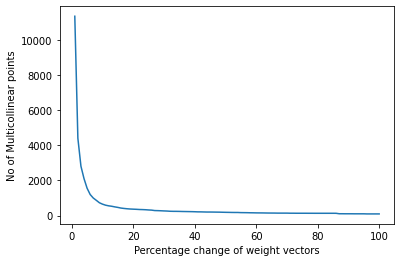

In [56]:
percentage_change = []
delta_i = []

for i in range(1,101,1):
  f= np.where(reverse_array > i )[1].size
  percentage_change.append(i)
  delta_i.append(f)
  

plt.xlabel('Percentage change of weight vectors')
plt.ylabel('No of Multicollinear points')
plt.plot(percentage_change,delta_i)

## DISPLAY THE LIST OF MULTICOLLINEAR FEATURES 

In [0]:
feat = count_vector.get_feature_names()
print("No of features have weight changes greater than 30%: ", percentage_difference[np.where(percentage_difference > 30)].size)
feature_names=[]
print("\nHence below features are multi collinear:")
for i in np.where(percentage_difference > 1)[1]:
    feature_names.append(feat[i])
print(feature_names)

No of features have weight changes greater than 30%:  190

Hence below features are multi collinear:
['aaaah', 'aaah', 'aaahhhhhh', 'ab', 'aberdeen', 'abi', 'abita', 'abnorm', 'abovement', 'abruzzo', 'abscond', 'absolulti', 'absorpt', 'accedi', 'acceler', 'acclaim', 'accor', 'acctural', 'accumul', 'aceit', 'acerb', 'acesuflamek', 'acetylcholin', 'acidifi', 'acidolphilus', 'acidophil', 'ack', 'acrid', 'action', 'actual', 'acumen', 'acupressur', 'acupunctur', 'acuraci', 'adapt', 'adaptogen', 'addat', 'address', 'adivc', 'adjac', 'ado', 'adobo', 'adolphus', 'advanceshield', 'advion', 'aer', 'affair', 'afficionado', 'aficionado', 'aflatoxin', 'afrikaan', 'afteral', 'afterbit', 'afternooon', 'afteroon', 'afterward', 'aggress', 'aggrev', 'agrument', 'agrumento', 'ahh', 'ahhhaahhh', 'ahhhhh', 'ahhhhhh', 'ahi', 'ahmad', 'ahnd', 'ahv', 'aid', 'aim', 'airflight', 'airhead', 'airplan', 'airwav', 'airy', 'ajanta', 'akron', 'alack', 'alan', 'alcat', 'alchol', 'aleighten', 'aleist', 'alfa', 'alfalfa

### FIND THE TOP 20 POSITIVE AND NEGATIVE FEATURES

In [0]:
feature_names = count_vector.get_feature_names()
coefs_with_fns = sorted(zip(logistic_reg_new.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

[((-2.1897087580522707, 'worst'), (1.4799395787392793, 'delici')),
 ((-1.622620925667345, 'disappoint'), (1.4381802487889659, 'excel')),
 ((-1.4680016561065057, 'horribl'), (1.338581505468097, 'perfect')),
 ((-1.4536479455687588, 'terribl'), (1.2757553991400303, 'best')),
 ((-1.3420854783555103, 'aw'), (1.2052891739908673, 'great')),
 ((-1.324114576615227, 'bland'), (1.136149304462042, 'yummi')),
 ((-1.3144308941094085, 'return'), (1.0849946002814685, 'addict')),
 ((-1.266831934326799, 'threw'), (1.0585243927196422, 'amaz')),
 ((-1.1413144677765867, 'unfortun'), (1.0050624821153975, 'awesom')),
 ((-1.124400385988919, 'stale'), (0.9842678362137236, 'refresh')),
 ((-1.0949639099000745, 'yuck'), (0.9643267000433828, 'beat')),
 ((-1.086558885923567, 'tasteless'), (0.9237078205821216, 'nice')),
 ((-1.0851015614217796, 'poor'), (0.9139233994354666, 'wonder')),
 ((-1.0567803708722718, 'dissapoint'), (0.8976226027764952, 'glad')),
 ((-1.031581732109198, 'unpleas'), (0.8933028806429271, 'smooth

In [0]:
def imp_features(model,classifier):
    voc = model.get_feature_names()
    w = list(classifier.coef_[0])
    pos_coef = []
    neg_coef = []
    pos_words = []
    neg_words = []
    for i,c in enumerate(w):
        if c > 0:
            pos_coef.append(c)
            pos_words.append(voc[i])
        if c < 0:
            neg_coef.append(abs(c))
            neg_words.append(voc[i])
    pos_df = pd.DataFrame(columns = ['Words','Coef'])
    neg_df = pd.DataFrame(columns = ['Words','Coef'])
    pos_df['Words'] = pos_words
    pos_df['Coef'] = pos_coef
    neg_df['Words'] = neg_words
    neg_df['Coef'] = neg_coef
    pos_df = pos_df.sort_values("Coef",axis = 0,ascending = False).reset_index(drop=True)
    neg_df = neg_df.sort_values("Coef",axis = 0,ascending = False).reset_index(drop=True)
    print("Shape of Positive dataframe:- ,",pos_df.shape)
    print("Shape of Negative dataframe:- ",neg_df.shape)
    print("Top ten positive predictors:- \n",pos_df.head(10))
    print("\nTop ten negative predictors:- \n",neg_df.head(10))    

## THE POSTIVE POINT = (21767,2) 
## THE NEGATIVE POINT = (7626,2)

In [0]:
imp_features(count_vector,logistic_reg_new)

Shape of Positive dataframe:- , (21767, 2)
Shape of Negative dataframe:-  (7626, 2)
Top ten positive predictors:- 
      Words      Coef
0   delici  1.479940
1    excel  1.438180
2  perfect  1.338582
3     best  1.275755
4    great  1.205289
5    yummi  1.136149
6   addict  1.084995
7     amaz  1.058524
8   awesom  1.005062
9  refresh  0.984268

Top ten negative predictors:- 
         Words      Coef
0       worst  2.189709
1  disappoint  1.622621
2     horribl  1.468002
3     terribl  1.453648
4          aw  1.342085
5       bland  1.324115
6      return  1.314431
7       threw  1.266832
8    unfortun  1.141314
9       stale  1.124400


### SPARSITY OF WEIGHT VECTOR ON BAG OF WORDS VECTORIZATION TECHNIQUE

In [0]:
logistic_reg_l1 = LogisticRegression(C=best_c,random_state=None, class_weight=None,penalty='l1',solver='liblinear')
logistic_reg_l1.fit(X_Train_data_bow,Y_Train)
weight_w1_l1=logistic_reg_l1.coef_

In [0]:
imp_features(count_vector,logistic_reg_l1)

Shape of Positive dataframe:- , (382, 2)
Shape of Negative dataframe:-  (373, 2)
Top ten positive predictors:- 
      Words      Coef
0   delici  1.576014
1    excel  1.445582
2  perfect  1.383116
3     best  1.229966
4    yummi  1.215222
5    great  1.168915
6     amaz  1.160982
7   addict  1.103060
8   awesom  1.036212
9  refresh  1.012890

Top ten negative predictors:- 
         Words      Coef
0       worst  2.644614
1  disappoint  1.603224
2     horribl  1.597010
3     terribl  1.553291
4          aw  1.440146
5       threw  1.365178
6        yuck  1.350889
7      return  1.318721
8       bland  1.274205
9    unfortun  1.198295


In [0]:
logistic_reg_new_l1 = LogisticRegression(C=best_c,random_state=None, class_weight=None,penalty='l1',solver='liblinear')
logistic_reg_new_l1.fit(noise_data,Y_Train)
weight_w2=logistic_reg_new_l1.coef_

## AFTER SPARSITY , THE NUMBER OF ZEROS REMOVED 
## THE POSITIVE DATAPOINT = (382,2)
## AND THE NEGATIVE DATAPOINT = (372,2)

In [0]:
imp_features(count_vector,logistic_reg_new_l1)

Shape of Positive dataframe:- , (382, 2)
Shape of Negative dataframe:-  (372, 2)
Top ten positive predictors:- 
      Words      Coef
0   delici  1.585864
1    excel  1.454302
2  perfect  1.391040
3     best  1.236530
4    yummi  1.221394
5    great  1.175115
6     amaz  1.166880
7   addict  1.107871
8   awesom  1.040926
9  refresh  1.015497

Top ten negative predictors:- 
         Words      Coef
0       worst  2.658635
1  disappoint  1.613068
2     horribl  1.607020
3     terribl  1.562023
4          aw  1.448828
5       threw  1.373219
6        yuck  1.354739
7      return  1.325813
8       bland  1.280382
9    unfortun  1.205609


## TF-IDF Vectorization Technique on Logistic Regression Algorithm

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

print(X_Train.shape, Y_Train.shape)
print(X_CV.shape, Y_CV.shape)
print(X_Test.shape, Y_Test.shape)

print("="*100)


tfidf_vector=TfidfVectorizer(min_df=10)
X_Train_data_tfidf=(tfidf_vector.fit_transform(X_Train['Cleaned_text'].values))
X_Test_data_tfidf=(tfidf_vector.transform(X_Test['Cleaned_text'].values))
X_CV_data_tfidf=(tfidf_vector.transform(X_CV['Cleaned_text'].values))

print("After vectorizations")
print(X_Train_data_tfidf.shape, Y_Train.shape)
print(X_CV_data_tfidf.shape, Y_CV.shape)
print(X_Test_data_tfidf.shape, Y_Test.shape)
print("="*100)

(64000, 12) (64000,)
(16000, 12) (16000,)
(20000, 12) (20000,)
After vectorizations
(64000, 6794) (64000,)
(16000, 6794) (16000,)
(20000, 6794) (20000,)


0.940703952138698
{'C': 1}


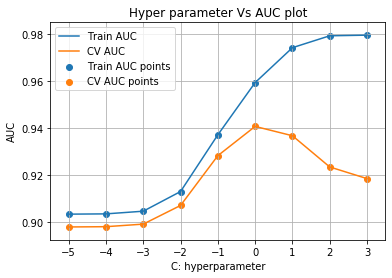

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.223514,0.006442,0.014594,0.000381,1e-05,{'C': 1e-05},0.898880,0.900700,0.895971,0.897278,0.894968,0.906497,0.896815,0.898146,0.898021,0.893408,0.898068,0.003414,9,0.903783,0.903030,0.904050,0.903812,0.903951,0.902578,0.902994,0.903685,0.903858,0.903268,0.903501,0.000472
1,0.182328,0.001241,0.014044,0.000183,0.0001,{'C': 0.0001},0.898969,0.900827,0.896087,0.897397,0.895064,0.906632,0.896941,0.898231,0.898117,0.893562,0.898183,0.003415,8,0.903899,0.903149,0.904164,0.903930,0.904067,0.902692,0.903114,0.903802,0.903975,0.903387,0.903618,0.000471
2,0.206218,0.002766,0.013947,0.000166,0.001,{'C': 0.001},0.899903,0.902008,0.897106,0.898557,0.895965,0.907762,0.898215,0.899173,0.899074,0.894996,0.899276,0.003399,7,0.905032,0.904288,0.905267,0.905056,0.905205,0.903801,0.904271,0.904951,0.905101,0.904541,0.904751,0.000469
3,0.281825,0.003033,0.014030,0.000241,0.01,{'C': 0.01},0.906732,0.910477,0.904298,0.906898,0.902603,0.916517,0.907079,0.906258,0.906317,0.904712,0.907189,0.003678,6,0.913340,0.912714,0.913453,0.913364,0.913568,0.911995,0.912768,0.913375,0.913389,0.912970,0.913094,0.000461
4,0.614663,0.043245,0.014329,0.000435,0.1,{'C': 0.1},0.926466,0.931131,0.925219,0.928125,0.922530,0.939979,0.929531,0.925905,0.926550,0.927601,0.928304,0.004488,3,0.937291,0.937056,0.937368,0.937296,0.937636,0.935834,0.937028,0.937566,0.937302,0.937080,0.937146,0.000478


In [0]:
results,best_c,Logistic_Regression_Optimal_C = Logistic_Regression_Optimal_C(X_Train_data_tfidf,Y_Train)
results.head()

In [0]:
best_C = best_c.best_params_
best_c=best_C.get("C")
print(best_c)

1


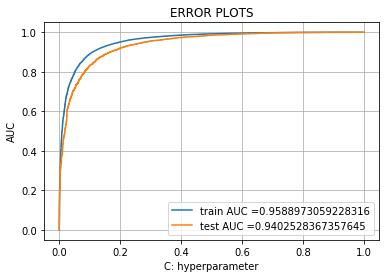

In [0]:
logistic_reg = LogisticRegression(C=best_c,random_state=None, class_weight=None)
logistic_reg.fit(X_Train_data_tfidf,Y_Train)
pred_test_data=logistic_reg.predict(X_Test_data_tfidf)
y_train_predicted_prob = logistic_reg.predict_proba(X_Train_data_tfidf)[:,1]
y_test_predicted_prob=logistic_reg.predict_proba(X_Test_data_tfidf)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [0]:
feature_names = tfidf_vector.get_feature_names()
print(feature_names)
coefs_with_fns = sorted(zip(logistic_reg.coef_[0], feature_names))
top_features = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
list(top_features)

['abandon', 'abc', 'abdomin', 'abil', 'abl', 'abnorm', 'abroad', 'absenc', 'absolut', 'absorb', 'absorpt', 'absurd', 'abund', 'abus', 'academi', 'acai', 'accent', 'accept', 'access', 'accid', 'accident', 'accommod', 'accompani', 'accomplish', 'accord', 'account', 'accur', 'accustom', 'acerola', 'ach', 'achiev', 'acid', 'acknowledg', 'acn', 'acquaint', 'acquir', 'acr', 'acrid', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adagio', 'adam', 'adapt', 'add', 'addict', 'addit', 'address', 'adequ', 'adher', 'adhes', 'adjust', 'administ', 'admir', 'admit', 'adobo', 'adopt', 'ador', 'adult', 'adulter', 'advanc', 'advantag', 'adventur', 'advers', 'advert', 'advertis', 'advic', 'advis', 'advoc', 'aerat', 'aero', 'aerogarden', 'aerogrow', 'aesthet', 'affair', 'affect', 'afficionado', 'affili', 'afford', 'afghanistan', 'aficionado', 'aforement', 'afraid', 'africa', 'african', 'afterlif', 'afternoon', 'aftertast', 'afterward', 'agav', 'age', 'agenc', 'agent', 'aggrav', 'aggress', 'a

[((-7.748687485272045, 'disappoint'), (10.339448027879326, 'great')),
 ((-7.622673795053763, 'worst'), (8.486116395757557, 'best')),
 ((-5.9005000634955875, 'terribl'), (7.68466693659498, 'delici')),
 ((-5.579915691392207, 'horribl'), (7.3817152671250845, 'love')),
 ((-5.295137172971102, 'aw'), (6.762914343760864, 'perfect')),
 ((-5.040232601297126, 'bland'), (6.3577495135318225, 'excel')),
 ((-4.9987251867463165, 'return'), (5.1498910605369135, 'nice')),
 ((-4.8335094257523865, 'stale'), (5.148119141672898, 'favorit')),
 ((-4.772733337902024, 'threw'), (5.074128994392021, 'amaz')),
 ((-4.675868642865835, 'tasteless'), (5.068752716930844, 'good')),
 ((-4.530295948623052, 'unfortun'), (5.023669033728019, 'wonder')),
 ((-4.205660835924637, 'weak'), (4.240576065719856, 'addict')),
 ((-4.173129569188836, 'money'), (4.089643153159445, 'yummi')),
 ((-4.120068588911006, 'wast'), (3.8270174695946784, 'awesom')),
 ((-3.8335856171096605, 'wors'), (3.7711143383792556, 'alway')),
 ((-3.76056077294

In [0]:
roc_auc_score(Y_Test,y_test_predicted_prob)

0.9402528367357645

In [0]:
print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.83      0.50      0.62      2457
    positive       0.93      0.99      0.96     17543

    accuracy                           0.93     20000
   macro avg       0.88      0.74      0.79     20000
weighted avg       0.92      0.93      0.92     20000

[[ 1218  1239]
 [  255 17288]]


## Avg Word2Vec Vectorization Technique on Logistic Regression Algorithm

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

list_of_sent_train_avgw2v=[]
list_of_sent_test_avgw2v=[]
list_of_sent_cv_avgw2v=[]
for sent_train_avgw2v in tqdm(X_Train['Cleaned_text'].values):
    list_of_sent_train_avgw2v.append(sent_train_avgw2v.split())

100%|██████████| 64000/64000 [00:00<00:00, 101284.36it/s]


In [0]:
for sent_test_avgw2v in tqdm(X_Test['Cleaned_text'].values):
    list_of_sent_test_avgw2v.append(sent_test_avgw2v.split())
    
for sent_cv_avgw2v in tqdm(X_CV['Cleaned_text'].values):
    list_of_sent_cv_avgw2v.append(sent_cv_avgw2v.split())

100%|██████████| 16000/16000 [00:00<00:00, 201002.38it/s]


In [0]:
w2v_model_train = Word2Vec(list_of_sent_train_avgw2v,min_count=5,size=50,workers=4)
w2v_words_Logistic_reg_train=list(w2v_model_train.wv.vocab)

In [0]:
w2v_model_test = Word2Vec(list_of_sent_test_avgw2v,min_count=5,size=50,workers=4)
w2v_words_Logistic_reg_test=list(w2v_model_test.wv.vocab)

In [0]:
w2v_model_cv = Word2Vec(list_of_sent_cv_avgw2v,min_count=5,size=50,workers=4)
w2v_words_Logistic_reg_cv=list(w2v_model_cv.wv.vocab)

In [0]:
print(len(w2v_words_Logistic_reg_train))
print(w2v_words_Logistic_reg_train[0:50])

10246
['continu', 'enjoy', 'dove', 'dark', 'chocol', 'order', 'receiv', 'par', 'one', 'reason', 'close', 'expir', 'date', 'distribut', 'consum', 'short', 'receipt', 'second', 'everi', 'bar', 'color', 'smooth', 'great', 'tast', 'chalki', 'white', 'bitter', 'even', 'look', 'though', 'melt', 'pour', 'wrapper', 'absolut', 'love', 'product', 'share', 'mani', 'friend', 'equal', 'delight', 'would', 'purchas', 'without', 'hesit', 'quit', 'dissappoint', 'deliveri', 'time', 'push']


In [0]:
train_vectors=[];
for sent in list_of_sent_train_avgw2v:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_Logistic_reg_train:
            vec=w2v_model_train.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

64000
50


In [0]:
test_vectors=[];
for sent in list_of_sent_test_avgw2v:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_Logistic_reg_test:
            vec=w2v_model_test.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

20000
50


In [0]:
cv_vectors=[];
for sent in list_of_sent_cv_avgw2v:
    sent_vec=np.zeros(50)
    cnt_words=0;
    for word in sent:
        if word in w2v_words_Logistic_reg_cv:
            vec=w2v_model_cv.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    cv_vectors.append(sent_vec)
print(len(cv_vectors))
print(len(cv_vectors[0]))

16000
50


0.8916826145952774
{'C': 1}


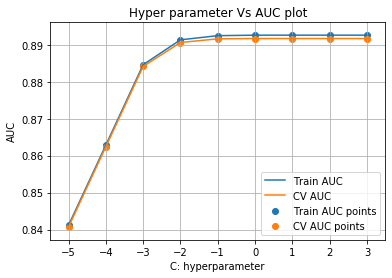

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.440008,0.010672,0.040468,0.006611,1e-05,{'C': 1e-05},0.839766,0.830403,0.844125,0.845508,0.845092,0.847584,0.840284,0.834949,0.834959,0.844485,0.840715,0.005376,9,0.840097,0.839422,0.838771,0.840361,0.840840,0.842481,0.843342,0.842940,0.842631,0.840779,0.841167,0.001503
1,0.460969,0.008436,0.039006,0.000848,0.0001,{'C': 0.0001},0.863514,0.855393,0.869674,0.867823,0.866962,0.866095,0.858876,0.855444,0.854978,0.865501,0.862426,0.005409,8,0.862129,0.861924,0.861029,0.862346,0.862549,0.863765,0.864291,0.864042,0.864015,0.862541,0.862863,0.001040
2,0.691445,0.008001,0.038812,0.000781,0.001,{'C': 0.001},0.886444,0.881964,0.895437,0.887896,0.889613,0.882109,0.879274,0.877316,0.874925,0.886391,0.884137,0.005883,7,0.884328,0.884410,0.883219,0.884430,0.884133,0.885149,0.885148,0.885297,0.885597,0.884347,0.884606,0.000664
3,1.172471,0.044348,0.038245,0.000290,0.01,{'C': 0.01},0.891425,0.889958,0.902040,0.893312,0.896411,0.886780,0.887714,0.883466,0.882427,0.892531,0.890606,0.005634,6,0.891257,0.891256,0.890001,0.891145,0.890830,0.891841,0.891616,0.892124,0.892223,0.891028,0.891332,0.000626
4,1.584745,0.055563,0.038497,0.000528,0.1,{'C': 0.1},0.891924,0.891071,0.902860,0.894313,0.897375,0.887535,0.889607,0.884015,0.884301,0.893013,0.891601,0.005488,5,0.892387,0.892457,0.891141,0.892191,0.891969,0.892989,0.892696,0.893309,0.893267,0.892186,0.892459,0.000620


In [0]:
results,best_c,Logistic_Regression_Optimal_C = Logistic_Regression_Optimal_C(train_vectors,Y_Train)
results.head()

In [0]:
best_C = best_c.best_params_
best_c=best_C.get("C")
print(best_c)

1


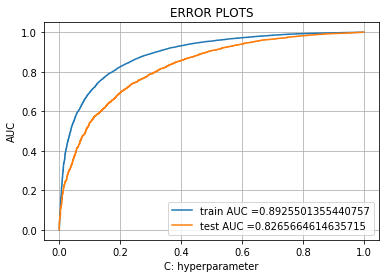

In [0]:
from sklearn.metrics import roc_curve, auc

logistic_reg = LogisticRegression(C=best_c,random_state=None, class_weight=None)
logistic_reg.fit(train_vectors,Y_Train)
pred_test_data=logistic_reg.predict(test_vectors)
y_train_predicted_prob = logistic_reg.predict_proba(train_vectors)[:,1]
y_test_predicted_prob=logistic_reg.predict_proba(test_vectors)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

roc_auc_score(Y_Test,y_test_predicted_prob)

0.8265664614635715

In [0]:
print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.75      0.01      0.01      2457
    positive       0.88      1.00      0.93     17543

    accuracy                           0.88     20000
   macro avg       0.81      0.50      0.47     20000
weighted avg       0.86      0.88      0.82     20000

[[   15  2442]
 [    5 17538]]


## TF-IDF Word2Vec Vectorization Technique for Logistic Regression on Amazon Fine Food Review

In [0]:
model_Avgw2v = TfidfVectorizer()
X_Train_Avgw2v=model_Avgw2v.fit_transform(X_Train['Cleaned_text'].values)

In [0]:
X_Test_Avgw2v=model_Avgw2v.transform(X_Test['Cleaned_text'].values)
X_CV_Avgw2v=model_Avgw2v.transform(X_CV['Cleaned_text'].values)

In [0]:
dictionary = dict(zip(model_Avgw2v.get_feature_names(), list(model_Avgw2v.idf_)))

In [0]:
tfidf_feature=model_Avgw2v.get_feature_names()

tfidf_sent_vectors_train=[];
#final_tf_idf = [];
row=0;

for sent in tqdm(list_of_sent_train_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_Logistic_reg_train and word in tfidf_feature :
            vec=w2v_model_train.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feature.index(word)]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row+=1

100%|██████████| 64000/64000 [12:17<00:00, 110.80it/s]


In [0]:
tfidf_sent_vectors_test=[];
#final_tf_idf = [];
row=0;

for sent in tqdm(list_of_sent_test_avgw2v):
    sent_vec=np.zeros(50)
    weight_sum=0;
    for word in sent :
        if word in w2v_words_Logistic_reg_test and word in tfidf_feature :
            vec=w2v_model_test.wv[word]
            #tf_idf=final_tf_idf[row,tfidf_feature.index(word)]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1

100%|██████████| 20000/20000 [03:48<00:00, 87.35it/s]


0.8673362513641042
{'C': 0.1}


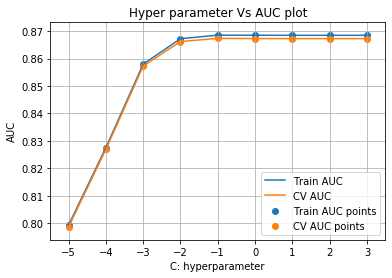

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.467593,0.010707,0.039096,0.001151,1e-05,{'C': 1e-05},0.809282,0.797226,0.799375,0.791666,0.779877,0.803385,0.803838,0.795537,0.801208,0.804749,0.798614,0.007871,9,0.799657,0.797732,0.799523,0.798343,0.801003,0.799045,0.799319,0.799351,0.799340,0.799199,0.799251,0.000807
1,0.480854,0.005201,0.039248,0.001363,0.0001,{'C': 0.0001},0.834692,0.827639,0.828188,0.823253,0.808282,0.829981,0.831220,0.824202,0.829459,0.831494,0.826841,0.006971,8,0.827480,0.826527,0.827560,0.827253,0.829253,0.827277,0.827603,0.827424,0.827381,0.827150,0.827491,0.000655
2,0.718839,0.010308,0.038745,0.000836,0.001,{'C': 0.001},0.863065,0.859881,0.859227,0.855291,0.840429,0.858673,0.858376,0.855736,0.859938,0.861355,0.857197,0.006009,7,0.857381,0.857630,0.857747,0.858220,0.859567,0.857700,0.858093,0.857947,0.857644,0.857424,0.857935,0.000601
3,1.343019,0.066285,0.039566,0.000806,0.01,{'C': 0.01},0.871818,0.868895,0.867375,0.863984,0.850901,0.868529,0.865603,0.862757,0.869871,0.872110,0.866184,0.005876,6,0.866636,0.867052,0.867176,0.867501,0.868805,0.866804,0.867274,0.867470,0.866812,0.866552,0.867208,0.000617
4,1.728029,0.072872,0.038878,0.000352,0.1,{'C': 0.1},0.872574,0.869171,0.867665,0.865074,0.852681,0.870448,0.867444,0.862687,0.871667,0.873951,0.867336,0.005870,1,0.867977,0.868436,0.868525,0.868798,0.870122,0.867996,0.868488,0.868836,0.868098,0.867809,0.868509,0.000633


In [0]:
results,best_c,Logistic_Regression_Optimal_C = Logistic_Regression_Optimal_C(tfidf_sent_vectors_train,Y_Train)
results.head()

In [0]:
best_C = best_c.best_params_
best_c=best_C.get("C")
print(best_c)

0.1


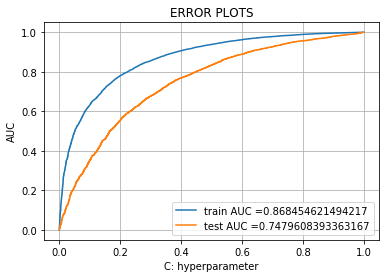

In [0]:
from sklearn.metrics import roc_curve, auc

logistic_reg = LogisticRegression(C=best_c,random_state=None, class_weight=None)
logistic_reg.fit(tfidf_sent_vectors_train,Y_Train)
pred_test_data=logistic_reg.predict(tfidf_sent_vectors_test)
y_train_predicted_prob = logistic_reg.predict_proba(tfidf_sent_vectors_train)[:,1]
y_test_predicted_prob=logistic_reg.predict_proba(tfidf_sent_vectors_test)[:,1]
train_fpr, train_tpr, train_thresholds=roc_curve(Y_Train,y_train_predicted_prob,pos_label='positive')
test_fpr, test_tpr, test_thresholds = roc_curve(Y_Test, y_test_predicted_prob,pos_label='positive')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

roc_auc_score(Y_Test,y_test_predicted_prob)

0.7479608393363167

In [0]:
print(classification_report(Y_Test,pred_test_data))
print(confusion_matrix(Y_Test,pred_test_data))

              precision    recall  f1-score   support

    negative       0.38      0.05      0.09      2457
    positive       0.88      0.99      0.93     17543

    accuracy                           0.87     20000
   macro avg       0.63      0.52      0.51     20000
weighted avg       0.82      0.87      0.83     20000

[[  130  2327]
 [  214 17329]]


In [0]:
pip install -U PTable

  Created wheel for PTable: filename=PTable-0.9.2-cp36-none-any.whl size=22908 sha256=47f54d5b1c93581e6d9d5a49e612518dbb2062b206b92b21e3543afa1ad79684
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [0]:
from prettytable import PrettyTable

x= PrettyTable()
x.field_names = ["Vectorizer" , "Hyperparameter", "AUC"]
x.add_row(["Bag Of Words",0.1,0.923486])
x.add_row(["Tf-Idf",1,0.945869])
x.add_row(["Avg Word2Vec ", 1,0.826496])
x.add_row(["Avg Tf-Idf",0.1,0.723985])
print(x)

+---------------+----------------+----------+
|   Vectorizer  | Hyperparameter |   AUC    |
+---------------+----------------+----------+
|  Bag Of Words |      0.1       | 0.923486 |
|     Tf-Idf    |       1        | 0.945869 |
| Avg Word2Vec  |       1        | 0.826496 |
|   Avg Tf-Idf  |      0.1       | 0.723985 |
+---------------+----------------+----------+


## CONCLUSION 
## BEST C = 1 , ACCURACY = 0.94589 USING TF-IDF EATUREIZATION TECHNIQUE 
## BAG OF WORDS AND TF-IDF PERFORMED WELL 
## AFTER SPARSITY THE DATAPOINT DRACTICALLY GET REDUCED.

In [0]:
.....